In [1]:
import findspark
findspark.init()
findspark.find()

import requests
import feedparser
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from datetime import datetime
import pytz
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

# Initialize Spark
appName = "Project - Machine Learning Techniques on MQTT"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)


# Create Spark Context with the new configurations rather than relying on the default
sc = SparkContext.getOrCreate(conf=conf)
# You need to create SQL Context to conduct some database operations like what we will
sqlContext = SQLContext(sc)
# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()


# spark = SparkSession.builder.master("local[*]").appName("sparktest").getOrCreate()

C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# **Load Data**

In [2]:
train_path = r"C:\Users\nickc\OneDrive\Documents\GitHub\course-project-option-2-nick1117\DataFolder\archive\Data\FINAL_CSV\train70_augmented.csv"
train_data = spark.read.csv(train_path, header=True, inferSchema=True)

test_path = r"C:\Users\nickc\OneDrive\Documents\GitHub\course-project-option-2-nick1117\DataFolder\archive\Data\FINAL_CSV\test30_augmented.csv"
test_data = spark.read.csv(test_path, header=True, inferSchema=True)

In [3]:
print(train_data.count())

14000000


In [3]:
from pyspark.sql.functions import lit

train_df = train_data.withColumn("dataset_type", lit("train"))
test_df = test_data.withColumn("dataset_type", lit("test"))
df = train_df.union(test_df)

In [6]:
len(train_df.columns)
len(test_df.columns)

35

In [4]:
db_properties = {}
db_properties['username'] = "postgres"
db_properties['password'] = "Nicknac1117+"
db_properties['url'] = "jdbc:postgresql://localhost:5432/postgres"
#db_properties['table'] = "FinalProject"
db_properties['table'] = "mqtt.FinalProject" 
db_properties['driver'] = "org.postgresql.Driver"

#db_properties['table'] = f"mqtt.{db_properties['table']}"

df.write.format("jdbc")\
    .mode("overwrite")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("driver", db_properties['driver'])\
    .save()

df_read = spark.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

#almost 5mins

In [2]:
db_properties = {}
db_properties['username'] = "postgres"
db_properties['password'] = "Nicknac1117+"
db_properties['url'] = "jdbc:postgresql://localhost:5432/postgres"
#db_properties['table'] = "FinalProject"
db_properties['table'] = "mqtt.FinalProject" 
db_properties['driver'] = "org.postgresql.Driver"

df_read = spark.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

In [3]:
df = df_read

In [4]:
print(df.columns)

['tcp.flags', 'tcp.time_delta', 'tcp.len', 'mqtt.conack.flags', 'mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.uname', 'mqtt.conflag.willflag', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msg', 'mqtt.msgid', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt.qos', 'mqtt.retain', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.ver', 'mqtt.willmsg', 'mqtt.willmsg_len', 'mqtt.willtopic', 'mqtt.willtopic_len', 'target', 'dataset_type']


rename columns to represent what they are and to get rid of periods - 34 columns not including the added data_type

In [5]:
from pyspark.sql.functions import col

new_column_names = [
    "tcp_flags",
    "tcp_time_delta",
    "tcp_length",
    "mqtt_connack_flags",
    "mqtt_connack_reserved_flags",
    "mqtt_connack_session_present",
    "mqtt_connack_return_code",
    "mqtt_connect_clean_session_flag",
    "mqtt_connect_password_flag",
    "mqtt_connect_qos_level",
    "mqtt_connect_reserved_flag",
    "mqtt_connect_retain_flag",
    "mqtt_connect_username_flag",
    "mqtt_connect_will_flag",
    "mqtt_connect_flags",
    "mqtt_duplicate_flag",
    "mqtt_header_flags",
    "mqtt_keep_alive_interval",
    "mqtt_length",
    "mqtt_message",
    "mqtt_message_id",
    "mqtt_message_type",
    "mqtt_protocol_length",
    "mqtt_protocol_name",
    "mqtt_qos_level",
    "mqtt_retain_flag",
    "mqtt_subscription_qos_level",
    "mqtt_subscription_ack_qos_level",
    "mqtt_version",
    "mqtt_will_message",
    "mqtt_will_message_length",
    "mqtt_will_topic",
    "mqtt_will_topic_length",
    "target_class",
    "dataset_type"
]

df = df.toDF(*new_column_names)

# train_df = train_df.toDF(*new_column_names)
# test_df = test_df.toDF(*new_column_names)
# train_df = train_df.drop("dataset_type")
# test_df = test_df.drop("dataset_type")

train_df = df.filter(col("dataset_type") == "train")
test_df = df.filter(col("dataset_type") == "test")
# train_df = train_df[:2]
print(train_df.count())
print(test_df.count())

14000000
6000000


# **Task II**

In [6]:
from pyspark.sql.functions import col, avg, count
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank
import matplotlib.pyplot as plt

In [20]:
def calc_avg_message_length(df, dataset_type, target_value):

    filtered_df = df.filter(col("dataset_type") == dataset_type)
    filtered_df = filtered_df.filter(col("target_class") == target_value)

    avg_message_length = filtered_df.agg(avg("mqtt_length")).collect()[0][0]

    return avg_message_length

In [21]:
def analyze_target_values(df, target_value):
    #avgtcp message length
    filtered_df = df.filter(col("target_class") == target_value)
    avg_tcp_message_length = filtered_df.agg(avg("tcp_length")).collect()[0][0]

    #most popular header flags code
    most_popular_header_flag_row = (filtered_df
                                .groupBy("mqtt_header_flags")
                                .agg(count("*").alias("count"))
                                .orderBy(col("count").desc())
                                .first())

    #Get the mqtt_header_flags value from the first row
    most_popular_header_flag_code = most_popular_header_flag_row["mqtt_header_flags"]

    return avg_tcp_message_length, most_popular_header_flag_code


In [22]:
def most_freq_tcp_flags(df, x, y):
    #check variables
    if x < 0:
        raise ValueError("X must be a positive integer")
    if y < 0.0 or y > 5.0:
        raise ValueError("Y must be a float in the range of [0.0, 5.0]")
    
    print(f"Value of x is: {x}")
    print(f"Value of y is: {y}")

    #filter df for tcp_time_detla
    filtered_df = df.filter(col("tcp_time_delta") <= y)

    grouped_tcp_flags_df = (filtered_df
                            .groupBy("tcp_flags") 
                            .agg(count("*").alias("count"))) #count tcp_flags and change column name
                            #.orderBy(col("count").desc()))
    
    #grouped_tcp_flags_df.show()
    
    window = Window.orderBy(col("count").desc())
    
    ranked_df = (grouped_tcp_flags_df
                 .withColumn("rank", dense_rank().over(window))
                 .filter(col("rank") <= x))
    
    return ranked_df


In [10]:
# Show a histogram for the target values in the training, testing or combined dataset. 
#
# o Your code should accept an argument that defines if the histogram is 
#   shown for the training, testing or combined.  
#
# o In your ReadMe.md file, display all three histograms

def show_histogram(df, dataset_type):

    if dataset_type == "train":
        filtered_df = df.filter(col("dataset_type") == dataset_type)
    elif dataset_type == "test":
        filtered_df = df.filter(col("dataset_type") == dataset_type)
    elif dataset_type == "combined":
        filtered_df = df

    target_counts = (filtered_df
                     .groupBy("target_class")
                     .agg(count("*").alias("count")))
    
    target_counts_pd = target_counts.toPandas()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(target_counts_pd["target_class"], target_counts_pd["count"], color='skyblue')
    plt.title(f"Histogram of Target Values - {dataset_type.capitalize()} Dataset")
    plt.xlabel("Target Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()


In [23]:
average_length = calc_avg_message_length(df, "train", "legitimate")
print(f"Average MQTT message length for 'legitimate' in the training dataset: {average_length}")

Average MQTT message length for 'legitimate' in the training dataset: 6.523362428571429


In [15]:
avg_tcp_message_length, most_popular_header_flag_code = analyze_target_values(df, "legitimate")
print(f"Average TCP message length for 'legitimate' in the training dataset: {avg_tcp_message_length}")
print(f"With the most popular header flags' code being {most_popular_header_flag_code}")

Average TCP message length for 'legitimate' in the training dataset: 7.7844068
With the most popular header flags' code being 0x00000030


In [16]:
x = int(input("Enter a positive integer that represents most frequent X TCP flags: "))
y = float(input("Enter a float value between 0.0 and 5.0 that represents TCP time delta: "))

result_df = most_freq_tcp_flags(df, x, y)

result_df.show(truncate=False)

Value of x is: 5
Value of y is: 3.0
+----------+-------+----+
|tcp_flags |count  |rank|
+----------+-------+----+
|0x00000018|9855374|1   |
|0x00000010|7795125|2   |
|0x00000002|624308 |3   |
|0x00000012|624108 |4   |
|0x00000011|619166 |5   |
+----------+-------+----+



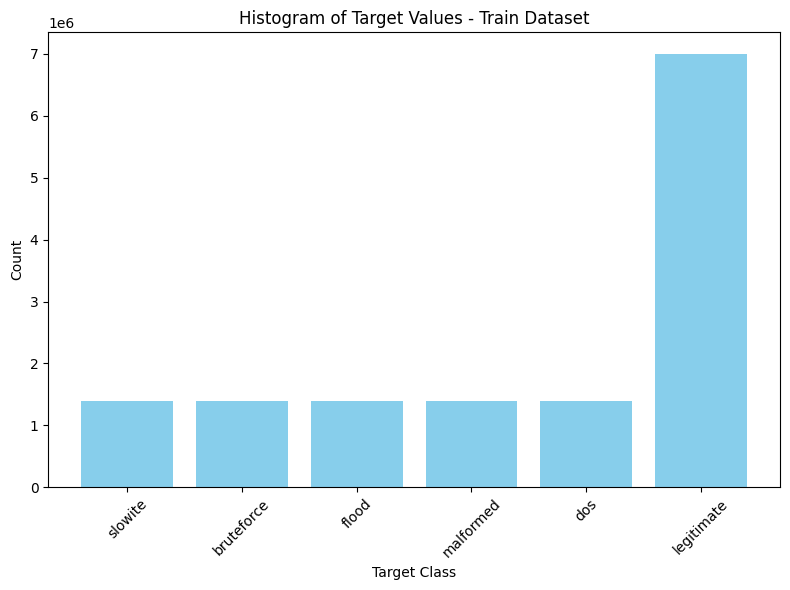

In [11]:
input_dataset_type = input("Enter dataset type ('train', 'test', 'combined'): ").strip().lower()

show_histogram(df, input_dataset_type)

# **Task III**

In [7]:
from pyspark.sql.functions import *

null_counts_plays_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df.columns])

null_counts_plays_df.show(truncate=False, vertical=True)

#zero null/nan values

-RECORD 0------------------------------
 tcp_flags                       | 0   
 tcp_time_delta                  | 0   
 tcp_length                      | 0   
 mqtt_connack_flags              | 0   
 mqtt_connack_reserved_flags     | 0   
 mqtt_connack_session_present    | 0   
 mqtt_connack_return_code        | 0   
 mqtt_connect_clean_session_flag | 0   
 mqtt_connect_password_flag      | 0   
 mqtt_connect_qos_level          | 0   
 mqtt_connect_reserved_flag      | 0   
 mqtt_connect_retain_flag        | 0   
 mqtt_connect_username_flag      | 0   
 mqtt_connect_will_flag          | 0   
 mqtt_connect_flags              | 0   
 mqtt_duplicate_flag             | 0   
 mqtt_header_flags               | 0   
 mqtt_keep_alive_interval        | 0   
 mqtt_length                     | 0   
 mqtt_message                    | 0   
 mqtt_message_id                 | 0   
 mqtt_message_type               | 0   
 mqtt_protocol_length            | 0   
 mqtt_protocol_name              | 0   


In [8]:
df.summary().show(truncate=False, vertical=True)

-RECORD 0---------------------------------------------------
 summary                         | count                    
 tcp_flags                       | 20000000                 
 tcp_time_delta                  | 20000000                 
 tcp_length                      | 20000000                 
 mqtt_connack_flags              | 20000000                 
 mqtt_connack_reserved_flags     | 20000000                 
 mqtt_connack_session_present    | 20000000                 
 mqtt_connack_return_code        | 20000000                 
 mqtt_connect_clean_session_flag | 20000000                 
 mqtt_connect_password_flag      | 20000000                 
 mqtt_connect_qos_level          | 20000000                 
 mqtt_connect_reserved_flag      | 20000000                 
 mqtt_connect_retain_flag        | 20000000                 
 mqtt_connect_username_flag      | 20000000                 
 mqtt_connect_will_flag          | 20000000                 
 mqtt_connect_flags     

In [9]:
df.dtypes

[('tcp_flags', 'string'),
 ('tcp_time_delta', 'double'),
 ('tcp_length', 'int'),
 ('mqtt_connack_flags', 'string'),
 ('mqtt_connack_reserved_flags', 'double'),
 ('mqtt_connack_session_present', 'double'),
 ('mqtt_connack_return_code', 'double'),
 ('mqtt_connect_clean_session_flag', 'double'),
 ('mqtt_connect_password_flag', 'double'),
 ('mqtt_connect_qos_level', 'double'),
 ('mqtt_connect_reserved_flag', 'double'),
 ('mqtt_connect_retain_flag', 'double'),
 ('mqtt_connect_username_flag', 'double'),
 ('mqtt_connect_will_flag', 'double'),
 ('mqtt_connect_flags', 'string'),
 ('mqtt_duplicate_flag', 'double'),
 ('mqtt_header_flags', 'string'),
 ('mqtt_keep_alive_interval', 'double'),
 ('mqtt_length', 'double'),
 ('mqtt_message', 'string'),
 ('mqtt_message_id', 'double'),
 ('mqtt_message_type', 'double'),
 ('mqtt_protocol_length', 'double'),
 ('mqtt_protocol_name', 'string'),
 ('mqtt_qos_level', 'double'),
 ('mqtt_retain_flag', 'double'),
 ('mqtt_subscription_qos_level', 'double'),
 ('mqtt_s

In [10]:
numeric_features = [feature[0] for feature in df.dtypes if feature[1] in ('int','double')]
numeric_features

['tcp_time_delta',
 'tcp_length',
 'mqtt_connack_reserved_flags',
 'mqtt_connack_session_present',
 'mqtt_connack_return_code',
 'mqtt_connect_clean_session_flag',
 'mqtt_connect_password_flag',
 'mqtt_connect_qos_level',
 'mqtt_connect_reserved_flag',
 'mqtt_connect_retain_flag',
 'mqtt_connect_username_flag',
 'mqtt_connect_will_flag',
 'mqtt_duplicate_flag',
 'mqtt_keep_alive_interval',
 'mqtt_length',
 'mqtt_message_id',
 'mqtt_message_type',
 'mqtt_protocol_length',
 'mqtt_qos_level',
 'mqtt_retain_flag',
 'mqtt_subscription_qos_level',
 'mqtt_subscription_ack_qos_level',
 'mqtt_version',
 'mqtt_will_message',
 'mqtt_will_message_length',
 'mqtt_will_topic',
 'mqtt_will_topic_length']

In [6]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1] in ('int','double')]

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [ ]:
df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_Outliers']<=4)
print(df_with_substituted_na_and_outliers.count())
correlation_matrix = df_with_substituted_na_and_outliers.toPandas().corr()
print(correlation_matrix)

In [12]:
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql import DataFrame

col_names = new_column_names
    # Define the columns
binary_cols = [
    "mqtt_connack_reserved_flags",
    "mqtt_connack_session_present",
    "mqtt_connect_clean_session_flag",
    "mqtt_connect_password_flag",
    "mqtt_connect_reserved_flag",
    "mqtt_connect_retain_flag",
    "mqtt_connect_username_flag",
    "mqtt_connect_will_flag",
    "mqtt_duplicate_flag",
    "mqtt_retain_flag",
    "mqtt_connect_qos_level"
]

nominal_cols = [
    "tcp_flags",
    "mqtt_connack_flags",
    "mqtt_connack_return_code",
    "mqtt_connect_flags",
    "mqtt_header_flags",
    "mqtt_message_type",
    "mqtt_qos_level",
    "mqtt_version",
    "mqtt_message",
    'mqtt_protocol_name'
]

continuous_cols = [
    "tcp_time_delta",
    "tcp_length",
    "mqtt_keep_alive_interval",
    "mqtt_length",
    "mqtt_protocol_length",
    "mqtt_will_message_length",
    "mqtt_will_topic_length",
    "mqtt_will_topic",
    "mqtt_will_message",
    "mqtt_subscription_ack_qos_level",
    "mqtt_subscription_qos_level",
    "mqtt_message_id"
]

class OutcomeCreater(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_multiclass = udf(lambda name:
                                  0.0 if name == 'legitimate' else
                                  1.0 if name == 'slowite' else
                                  2.0 if name == 'bruteforce' else
                                  3.0 if name == 'flood' else
                                  4.0 if name == 'malformed' else
                                  5.0 if name == 'dos' else
                                  -1.0, DoubleType())
        output_df = dataset.withColumn('outcome', label_to_multiclass(col('target_class')))
        output_df = output_df.drop("target_class")
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        return output_df
    
class FeatureTypeCaster(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset: DataFrame):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(DoubleType()))
        return output_df
    
class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop=None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Columns to remove
    corelated_cols_to_remove = ["mqtt_connack_reserved_flags", "mqtt_connack_session_present", "mqtt_connect_qos_level",
                                "mqtt_connect_reserved_flag", "mqtt_connect_retain_flag", "mqtt_connect_will_flag", "mqtt_message", 
                                "mqtt_subscription_qos_level", "mqtt_subscription_ack_qos_level", "mqtt_will_message",
                                "mqtt_will_message_length", "mqtt_will_topic", "mqtt_will_topic_length",'mqtt_protocol_name']

    # Stage where columns are cast as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Convert nominal columns to string type
    class NominalTypeCaster(Transformer):
        def __init__(self):
            super().__init__()

        def _transform(self, dataset):
            output_df = dataset
            for col_name in nominal_cols:
                output_df = output_df.withColumn(col_name, col(col_name).cast("string"))
            return output_df

    stage_nominal_typecaster = NominalTypeCaster()

    # Create a list of StringIndexers with handleInvalid='keep'
    stage_nominal_indexers = [
        StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='keep') 
        for col in nominal_cols
    ]

    # Create a list of OneHotEncoders with handleInvalid='keep'
    stage_nominal_onehot_encoders = [
        OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded", handleInvalid='keep') 
        for col in nominal_cols
    ]

    # Feature columns assembly
    feature_cols = continuous_cols + binary_cols + [col + "_encoded" for col in nominal_cols]

    # Remove correlated columns from features
    for col_name in corelated_cols_to_remove:
        if col_name in feature_cols:
            feature_cols.remove(col_name)
    print("NUMBER OF COLS", len(feature_cols))
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the features
    stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

    # Stage for creating the outcome column
    stage_outcome = OutcomeCreater()

    # Removing unnecessary columns
    columns_to_drop = (
        nominal_cols + 
        [col + "_index" for col in nominal_cols] + 
        [col + "_encoded" for col in nominal_cols] + 
        binary_cols + continuous_cols + ['vectorized_features']
    )
    stage_column_dropper = ColumnDropper(columns_to_drop=columns_to_drop)

    # Connect the stages into a pipeline
    stages = (
        [stage_typecaster, stage_nominal_typecaster] + 
        stage_nominal_indexers + 
        stage_nominal_onehot_encoders + 
        [stage_vector_assembler, stage_scaler, stage_outcome, stage_column_dropper]
    )
    pipeline = Pipeline(stages=stages)

    return pipeline


In [13]:
# def get_preprocess_pipeline():


#     # Columns to remove
#     corelated_cols_to_remove = ["mqtt_connack_reserved_flags", "mqtt_connack_session_present", "mqtt_connect_qos_level",
#                             "mqtt_connect_reserved_flag", "mqtt_connect_retain_flag", "mqtt_connect_will_flag", "mqtt_message", 
#                             "mqtt_subscription_qos_level", "mqtt_subscription_ack_qos_level", "mqtt_will_message",
#                             "mqtt_will_message_length", "mqtt_will_topic", "mqtt_will_topic_length",'mqtt_protocol_name']

#     # Stage where columns are cast as appropriate types
#     stage_typecaster = FeatureTypeCaster()

#     # Stage where nominal columns are transformed to index columns using StringIndexer
#     nominal_id_cols = [x + "_index" for x in nominal_cols]
#     nominal_onehot_cols = [x + "_encoded" for x in nominal_cols]
#     stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)

#     # Stage where the index columns are transformed using OneHotEncoder
#     stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

#     # Feature columns assembly
#     feature_cols = continuous_cols + binary_cols + nominal_onehot_cols

#     for col_name in corelated_cols_to_remove:
#         if col_name in feature_cols:
#             feature_cols.remove(col_name)

#     stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

#     # Stage where we scale the features
#     stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

#     # Stage for creating the outcome column
#     stage_outcome = OutcomeCreater()

#     # Removing unnecessary columns, keeping only 'features' and 'outcome'
#     columns_to_drop = nominal_cols + nominal_id_cols + nominal_onehot_cols + binary_cols + continuous_cols + ['vectorized_features']
#     stage_column_dropper = ColumnDropper(columns_to_drop=columns_to_drop)

#     # Connect the stages into a pipeline
#     pipeline = Pipeline(stages=[stage_typecaster, stage_nominal_indexer, stage_nominal_onehot_encoder, stage_vector_assembler, stage_scaler, stage_outcome, stage_column_dropper])

#     return pipeline

In [14]:
# Get the preprocessing pipeline
pipeline = get_preprocess_pipeline()

# Fit the pipeline to data
pipeline_model = pipeline.fit(train_df)

# Transform the data
train_df_preprocessed = pipeline_model.transform(train_df)
test_df_preprocessed = pipeline_model.transform(test_df)

# Cache the dataframes
train_df_final = train_df_preprocessed.cache()
test_df_final = test_df_preprocessed.cache()

#2m 17s

NUMBER OF COLS 21


In [15]:
train_df_final_slowmite = train_df_final.filter(col("outcome") == "1.0").count()

print(train_df_final_slowmite)

1400000


In [18]:
from pyspark.sql import functions as F

train_df_zeros = train_df_final.filter(F.col("outcome") == "0.0").sample(False, train_df_final_slowmite / train_df_final.filter(F.col("outcome") == "0.0").count())
print(train_df_zeros.count())

1401076


In [19]:
train_df_final = train_df_final.filter(F.col("outcome") != "0.0")
train_df_final = train_df_final.union(train_df_zeros)

print(train_df_final.count())

8401076


In [16]:
# Display the first few rows of the transformed training DataFrame
print("Training Data:")
train_df_final.show(n=10, truncate=False)  # Show 10 rows without truncating values

# Display the first few rows of the transformed testing DataFrame
print("Testing Data:")
test_df_final.show(n=10, truncate=False)  # Show 10 rows without truncating values

Training Data:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|features                                                                                                                                                                                                                                                                                                                                                                                                     |outcome|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define two classifiers
# Classifier 1: Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="outcome", maxIter=10)

# Classifier 2: Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="outcome", numTrees=20)

# Set up parameter grids for tuning
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1, 1.0])
                .addGrid(lr.maxIter, [1, 5, 10])
                .build())

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")

# Set up CrossValidator for Logistic Regression
lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

# Fit models
print("Training Logistic Regression Model...")
lr_model = lr_cv.fit(train_df_final)


# Evaluate on test data
print("Evaluating Logistic Regression Model...")
lr_predictions = lr_model.transform(test_df_final)
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Test Accuracy of Logistic Regression Model: {lr_accuracy}")


# Record the best models and parameters
best_lr_model = lr_model.bestModel

print("Best Logistic Regression Model Parameters:")
print(f"RegParam: {best_lr_model._java_obj.getRegParam()}")
print(f"MaxIter: {best_lr_model._java_obj.getMaxIter()}")

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20, 40])
                .addGrid(rf.maxDepth, [5, 10, 15])
                .build())

# Set up CrossValidator for Random Forest
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

print("Training Random Forest Model...")
rf_model = rf_cv.fit(train_df_final)

print("Evaluating Random Forest Model...")
rf_predictions = rf_model.transform(test_df_final)
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Test Accuracy of Random Forest Model: {rf_accuracy}")

best_rf_model = rf_model.bestModel

print("Best Random Forest Model Parameters:")
print(f"NumTrees: {best_rf_model.getNumTrees}")
print(f"MaxDepth: {best_rf_model.getMaxDepth()}")


In [12]:
from pyspark.sql.types import ArrayType, FloatType
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn
import numpy as np 
import pandas as pd

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType())) # keep as is

train_df_final, df_validate_final = train_df_final.randomSplit([0.8, 0.2], seed=42)

df_train_pandas = train_df_final.withColumn('features', to_array('features')).toPandas()
df_validate_pandas = df_validate_final.withColumn('features', to_array('features')).toPandas()
df_test_pandas = test_df_final.withColumn('features', to_array('features')).toPandas()

x_train = torch.from_numpy(np.array(df_train_pandas['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(df_train_pandas['outcome'].values.tolist(),np.int64))

x_validate = torch.from_numpy(np.array(df_validate_pandas['features'].values.tolist(),np.float32))
y_validate = torch.from_numpy(np.array(df_validate_pandas['outcome'].values.tolist(),np.int64))

x_test = torch.from_numpy(np.array(df_test_pandas['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(df_test_pandas['outcome'].values.tolist(),np.int64))

class MyDataset(Dataset): 
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)
validate_dataset = MyDataset(x_validate, y_validate)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61150)
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "C:\spark\spark-3.5.2-bin-hadoop3\python\p

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\nickc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\nickc\AppData\Local\Temp\ipykernel_23252\3725817056.py", line 12, in <module>
    df_train_pandas = train_df_final.withColumn('features', to_array('features')).toPandas()
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\pandas\conversion.py", line 202, in toPandas
    rows = self.collect()
           ^^^^^^^^^^^^^^
  File "C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\dataframe.py", line 1263, in collect
    sock_info = self._jdf.collectToPython()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\spark\spark-3.5.2-bin-hadoop

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [11]:

class ShallowMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, output_dim)
        )
        
    def forward(self, x):
        y = self.sequential(x)
        return y
    
class DeepMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )
        
    def forward(self, x):
        y = self.sequential(x)
        return y

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for x_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    
    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()
    
    test_accuracy = correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy

In [ ]:
input_dim = x_train.shape[1]
output_dim = len(torch.unique(y_train))

# Hyperparameter options
learning_rates = [0.01, 0.001]
num_epochs_list = [10, 20]
batch_sizes = [32, 64]

best_accuracy_shallow = 0.0
best_params_shallow = {}

for lr in learning_rates:
    for num_epochs in num_epochs_list:
        for batch_size in batch_sizes:
            print(f"Training ShallowMLP with lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}")
            # Update DataLoaders with new batch_size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            # Initialize model, criterion, and optimizer
            model = ShallowMLP(input_dim, output_dim)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # Train model
            test_accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
            # Record best model
            if test_accuracy > best_accuracy_shallow:
                best_accuracy_shallow = test_accuracy
                best_params_shallow = {'lr': lr, 'num_epochs': num_epochs, 'batch_size': batch_size}
                best_model_shallow = model.state_dict()